# Introduction

*   This notebook implements the "Double Q-learning" algorithm for the "CartPole-v0" environment. For more information on the environment, please visit [here](https://gym.openai.com/envs/CartPole-v0/#barto83). Also, check the related paper [here](https://ieeexplore.ieee.org/document/6313077).



*   The algorithm and the related text is copied and pasted from Section 6.7 of the book "Reinforcement Learning: An Introduction" by Richard S. Sutton and Andrew G. Barto (second edition).



*   You can download the book [here](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf).

# Maximization Bias and Double Learning

Maximization bias occurs when the maximum of the true values is zero, but the maximum of the estimates is positive, a positive bias.

Are there algorithms that avoid maximization bias? To start, consider a bandit case in which we have noisy estimates of the value of each of many actions, obtained as sample averages of the rewards received on all the plays with each action. As we discussed above, there will be a positive maximization bias if we use the maximum of the estimates as an estimate of the maximum of the true values. One way to view the problem is that it is due to using the same samples (plays) both to determine the maximizing action and to estimate its value. Suppose we divided the plays in two sets and used them to learn two independent estimates, call them $Q_{1}(a)$ and $Q_{2}(a)$, each an estimate of the true value $q(a)$, for all $a \in A$. We could then use one estimate, say $Q_{1}$, to determine the maximizing action $A^{*} = \arg \max_{a} Q_{1}(a)$, and the other, $Q_{2}$, to provide the estimate of its value, $Q_{2}(A^{*}) = Q_{2}(\arg \max_{a} Q_{1}(a))$. This estimate will then be unbiased in the sense that $E[Q_{2}(A^{*})] = q(A^{*})$. We can also repeat the process with the role of the two estimates reversed to yield a second unbiased estimate $Q_{1}(\arg \max_{a} Q_{2}(a))$. This is the idea of *double learning*. Note that although we learn two estimates, only one estimate is updated on each play; double learning doubles the memory requirements, but does not increase the amount of computation per step.

The idea of double learning extends naturally to algorithms for full MDPs. For example, the double learning algorithm analogous to Q-learning, called Double Q-learning, divides the time steps in two, perhaps by flipping a coin on each step. If the coin comes up heads, the update is

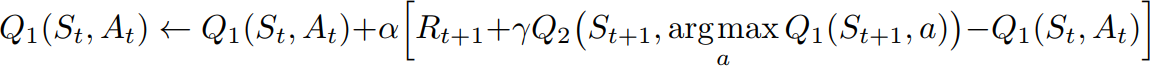

If the coin comes up tails, then the same update is done with $Q_{1}$ and $Q_{2}$ switched, so that $Q_{2}$ is updated. The two approximate value functions are treated completely symmetrically. The behavior policy can use both action-value estimates. For example, an $\epsilon$-greedy policy for Double Q-learning could be based on the averag (or sum) of the two action-value estimates.

Of course there are also double versions of Sarsa and Expected Sarsa.

**Algorithm**

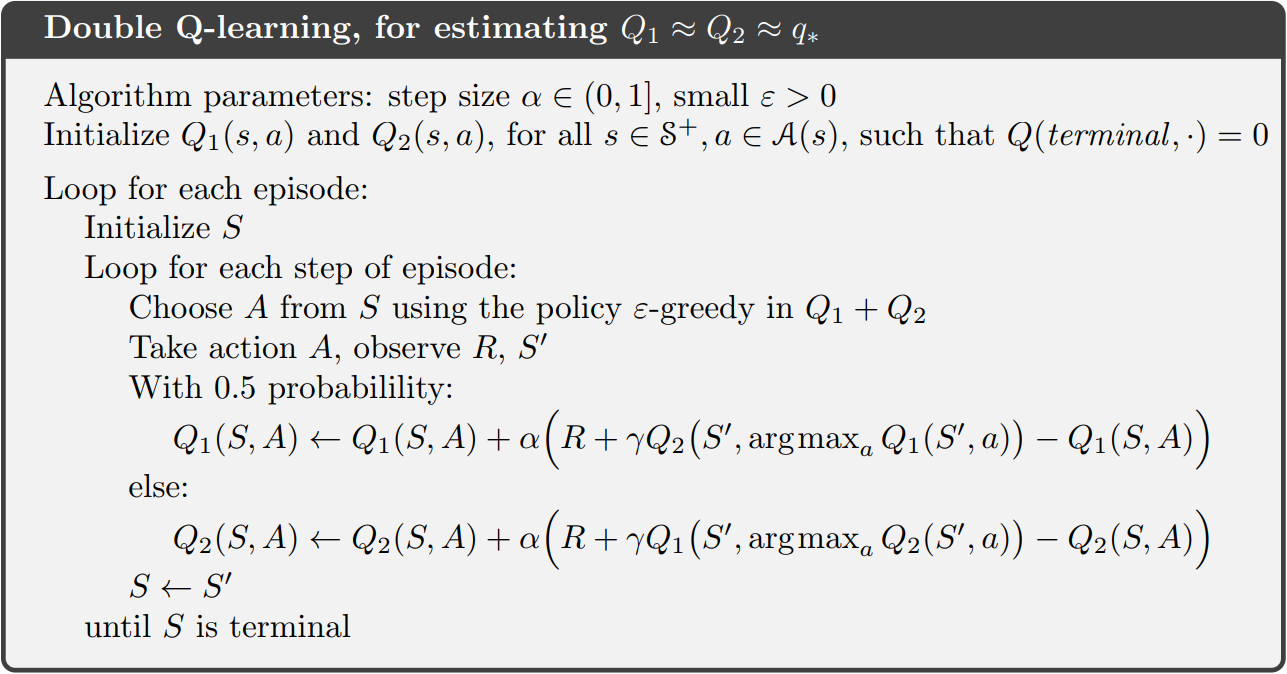

# Python Implementation

**Import Packages**

In [ ]:
import gym
import math
import numpy as np
import matplotlib.pyplot as plt

**Double Q-learning Agent**

In [ ]:
class Agent:

    def __init__(self, alpha, epsilon, gamma, state_space, action_space, num_actions):

        self.alpha = alpha  # step-size parameter
        self.epsilon = epsilon  # probability of taking a random action in an ε-greedy policy
        self.gamma = gamma  # discount-rate parameter (discount factor)
        self.state_space = state_space
        self.action_space = action_space
        self.num_actions = num_actions

        self.Q1, self.Q2 = {}, {}
        for s in self.state_space:
            for a in range(self.num_actions):
                self.Q1[s, a] = 0
                self.Q2[s, a] = 0

    def policy(self, state, cond):
        """
        Implement the ε-greedy action selection policy.
        """

        if cond == "0":
            q_values = np.array([self.Q1[state, a] + self.Q2[state, a] for a in range(self.num_actions)])
        elif cond == "1":
            q_values = np.array([self.Q1[state, a] for a in range(self.num_actions)])
        elif cond == "2":
            q_values = np.array([self.Q2[state, a] for a in range(self.num_actions)])

        r = np.random.random()

        if r < self.epsilon:
            action = self.action_space.sample()  # random action - exploration
        else:
            action = np.argmax(q_values)  # greedy action - exploitation

        return action

    def update_values(self, state, action, reward, state_):
        """
        Update the action-value estimates.
        """

        r = np.random.random()

        if r <= 0.5:
            action_ = self.policy(state_, "1")
            delta = reward + self.gamma * self.Q2[state_, action_] - self.Q1[state, action]  # TD error
            self.Q1[state, action] += self.alpha * delta
        else:
            action_ = self.policy(state_, "2")
            delta = reward + self.gamma * self.Q1[state_, action_] - self.Q2[state, action]  # TD error
            self.Q2[state, action] += self.alpha * delta

    def decrement_epsilon(self, episodes):
        """
        Decrease the value of ε after each episode.
        **Usage is optional.**
        """

        # This is to decrease the probability of taking a random action and ensure convergence with ε-greedy policies.
        # This is because as the action-value estimates change toward the optimal values, the need for exploration
        # decreases and more exploitation is needed.

        if self.epsilon > 0:
            self.epsilon -= 1 / episodes
        else:
            self.epsilon = 0

**Main Body**

In [ ]:
env = gym.make("CartPole-v0")
action_space = env.action_space  # Discrete(2) = [0, 1]
num_actions = 2
# print(env.observation_space.high)
# print(env.observation_space.low)

cart_position_bins = np.linspace(-2.4, 2.4, 19)  # 20 bins/buckets - [-2.4m 2.4m]
cart_velocity_bins = np.linspace(-4, 4, 19)  # 20 bins/buckets
pole_angle_bins = np.linspace(-12 * math.pi / 180, 12 * math.pi / 180, 19)  # 20 bins/buckets - [-12° 12°]
pole_angular_velocity_bins = np.linspace(-4, 4, 19)  # 20 bins/buckets
state_bins = [cart_position_bins, cart_velocity_bins, pole_angle_bins, pole_angular_velocity_bins]

state_space = []
for s1 in range(len(cart_position_bins) + 1):
    for s2 in range(len(cart_position_bins) + 1):
        for s3 in range(len(cart_position_bins) + 1):
            for s4 in range(len(cart_position_bins) + 1):
                state_space.append((s1, s2, s3, s4))


def discretize_obs_space(obs, bins):
    """
    Discretize the continuous observation space.
    """

    cart_position, cart_velocity, pole_angle, pole_angular_velocity = obs

    cart_position = int(np.digitize(cart_position, bins[0], right=False))
    cart_velocity = int(np.digitize(cart_velocity, bins[1], right=False))
    pole_angle = int(np.digitize(pole_angle, bins[2], right=False))
    pole_angular_velocity = int(np.digitize(pole_angular_velocity, bins[3], right=False))

    return cart_position, cart_velocity, pole_angle, pole_angular_velocity


alpha = 0.1  # step-size parameter
epsilon = 1.0  # probability of taking a random action in an ε-greedy policy
gamma = 0.99  # discount-rate parameter (discount factor)

agent = Agent(alpha, epsilon, gamma, state_space, action_space, num_actions)

episodes = 100000
total_rewards = []

for episode in range(1, episodes + 1):

    observation = env.reset()
    state = discretize_obs_space(observation, state_bins)
    done = False

    total_reward = 0
    steps = 0
    # actions = []

    while not done:

        # env.render()
        action = agent.policy(state, "0")
        observation_, reward, done, info = env.step(action)
        state_ = discretize_obs_space(observation_, state_bins)
        agent.update_values(state, action, reward, state_)
        state = state_

        total_reward += reward
        steps += 1
        # actions.append(action)

    agent.decrement_epsilon(episodes)
    total_rewards.append(total_reward)

    if episode % 1000 == 0:
        print(f"=============== Episode: {episode} ===============")
        print(f"Total Reward: {total_reward}")
        print(f"Steps: {steps}")
        # print(f"Actions: {actions}")

# env.close()

**Plot**

In [ ]:
x_axis = [i for i in range(1, episodes + 1)]
y_axis = total_rewards

plt.figure(figsize=(12, 6), dpi=100)

plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")

plt.plot(x_axis, y_axis)
plt.grid()
plt.show()

**Simulation Results**

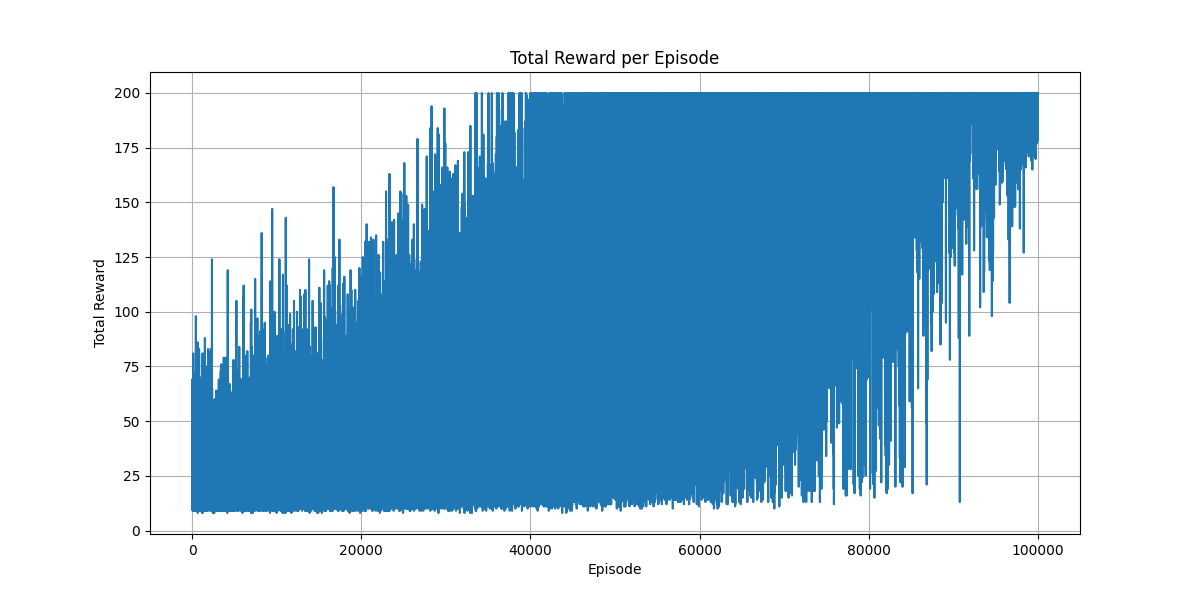